In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

from matplotlib import rcParams
rcParams["errorbar.capsize"] = 5
rcParams["lines.markeredgewidth"] = 2

from ali.ali_sw import *
from xps.xps_sw import *

In [2]:
jtplot.style('default', grid=False)

 - Correct area integration and stoichiometry results
 - Add ALI data
 - Fix fitting analysis:
  - Gaussian convolution
  - Voigt convolution
  - FWHM
  - Shake ups and other components
  - Proper O bg subtraction
 - Add ALI curves

# Dropcasting series

### Import data

In [3]:
path = '/Users/pabloherrero/sabat/xps_spectra/'
file_clean = path + '2019_10_28_Au_crystal_clean/20191028_Au(788)_clean.xy'
file_drop = path + '2019_10_28_FBI_dropcast_Au_crystal/20191028_FBI_dropcast_1mM_Au(788).xy'
file_sput1 = path + '2019_10_29_Au_crystal_clean/20191029_Au(788)_clean.xy'
file_sput2 = path + '2019_10_30_Au_crystal_sputter_2kev/20191030_FBI_Ba_Au(788)_sputter_2kev.xy'
file_sput3 = path + '2019_10_31_Au_crystal_sputter_2kev/20191031_FBI_Ba_Au(788)_2ndSputter_2kev.xy'

files = [file_clean, file_drop, file_sput1, file_sput2, file_sput3]

| Experiment | Sputtering [keV] | time [min]  |
|----------|:-------------:|----------:|
| Clean |  -  |  -  |
| Dropcasting |  -  |  -  |
| 1st round | 1.5 | 10 |
| 2nd round | 2 |  60 |
| 3rd round | 2 | 120 |

In [4]:
lb = ['Clean Au substrate', 'Dropcast FBI-region++ 1 mM', 'Sputter 1: 1.5 keV, 10 min', 'Sputter 2: 2 keV, 1h', 'Sputter 3: 2 keV, 2h']

Clean = XPSana(path = file_clean, name = lb[0])
Drop = XPSana(path = file_drop, name = lb[1])
Sput1 = XPSana(path = file_sput1, name = lb[2])
Sput2 = XPSana(path = file_sput2, name = lb[3])
Sput3 = XPSana(path = file_sput3, name = lb[4])

Clean.reverse_energy_scale()
data = [Clean, Drop, Sput1, Sput2, Sput3]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/2019_10_29_Au_crystal_clean/20191029_Au(788)_clean.xy'

## Plot overviews

### All Dropcast series overview

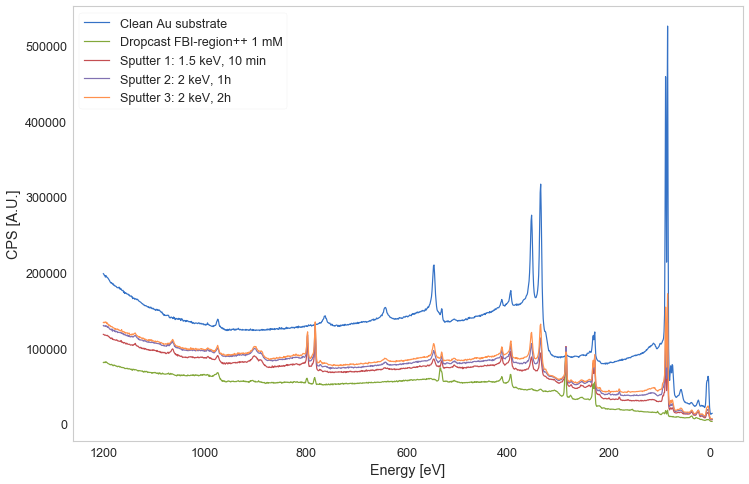

In [393]:
fig = plt.figure(figsize=(12, 8))
for j, d in enumerate(data):
    d.plot_region('overview')

### Au/Mo core levels

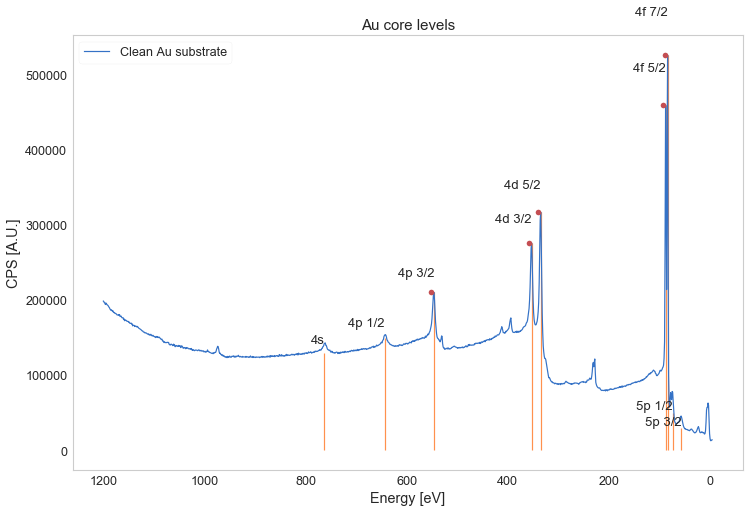

In [428]:
fig = plt.figure(figsize=(12,8))
Clean.plot_region('overview')
plt.title('Au core levels', fontsize = 15)
peaks_ov = find_and_plot_peaks(Clean.df['overview'], thres=0.38)

x = Clean.df.overview.energy.values[peaks_ov]
y = Clean.df.overview.counts.values[peaks_ov]

x = np.append(x, [643, 763, 74, 57])
y = np.append(y, [15e4, 13e4, 5e4, 3e4])
orb = ['4p 3/2', '4d 3/2' , '4d 5/2', '4f 5/2', '4f 7/2', '4p 1/2', '4s', '5p 1/2', '5p 3/2' ]
for xx, yy, s in zip(x, y, orb):
    plt.vlines(x = xx, ymin=0, ymax=yy, color = 'y')
    plt.text(s = s, x = xx, y = yy * 1.1, ha = 'right')

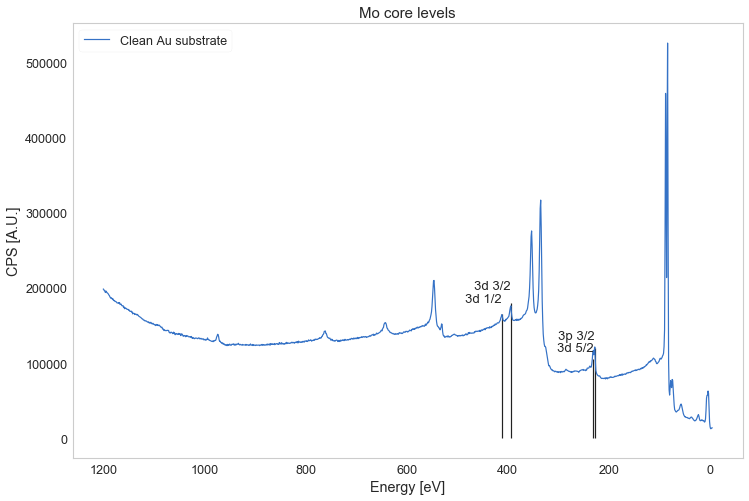

In [439]:
fig = plt.figure(figsize=(12,8))
Clean.plot_region('overview')
plt.title('Mo core levels', fontsize = 15)
xmo = [228, 231, 394, 412]
ymo = [12e4, 10.5e4, 18e4, 16.5e4]
omo = ['3p 3/2', '3d 5/2', '3d 3/2' , '3d 1/2']
la = ['Mo']
la.append('__nolegend__' for i in range(3))
for xx, yy, s in zip(xmo, ymo, omo):
    plt.vlines(x = xx, ymin=0, ymax=yy, color = 'k')#, label = la)
    plt.text(s = s, x = xx, y = yy * 1.1, ha = 'right')
plt.legend()

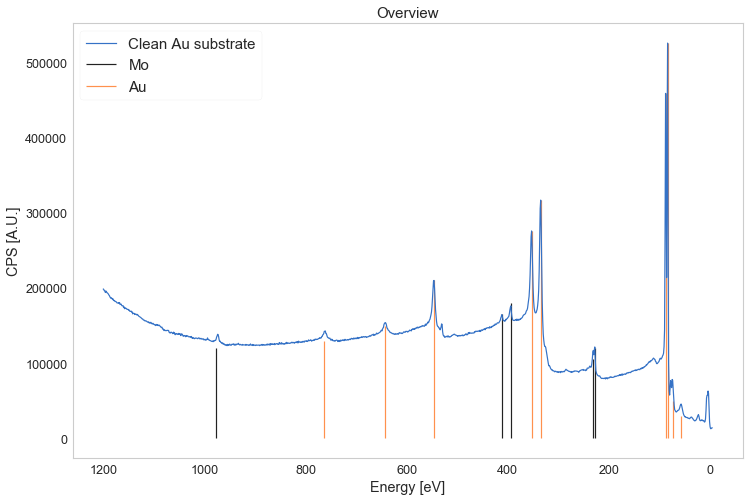

In [455]:
fig = plt.figure(figsize=(12,8))
Clean.plot_region('overview')
plt.title('Overview', fontsize = 15)
xmo = [228, 231, 394, 412]
ymo = [12e4, 10.5e4, 18e4, 16.5e4]
omo = ['3p 3/2', '3d 5/2', '3d 3/2' , '3d 1/2']

for i, (xx, yy) in enumerate(zip(xmo, ymo)):
    if i == 0 : la = 'Mo'
    else: la = '__nolegend__'
    plt.vlines(x = xx, ymin=0, ymax=yy, color = 'k', label = la)
#     plt.text(s = s, x = xx, y = yy * 1.1, ha = 'right')
for i, (xx, yy) in enumerate(zip(x, y)):
    if i == 0 : la = 'Au'
    else: la = '__nolegend__'
    plt.vlines(x = xx, ymin=0, ymax=yy, color = 'y', label = la)
#     plt.text(s = s, x = xx, y = yy * 1.1, ha = 'right')
plt.vlines(x = 978, ymin=0, ymax=12e4)
plt.legend(fontsize=15)

## Ba

In [16]:
region = 'Ba_3d'

### Spin-orbit splitting

Text(0.5, 1.0, 'Ba 3d region')

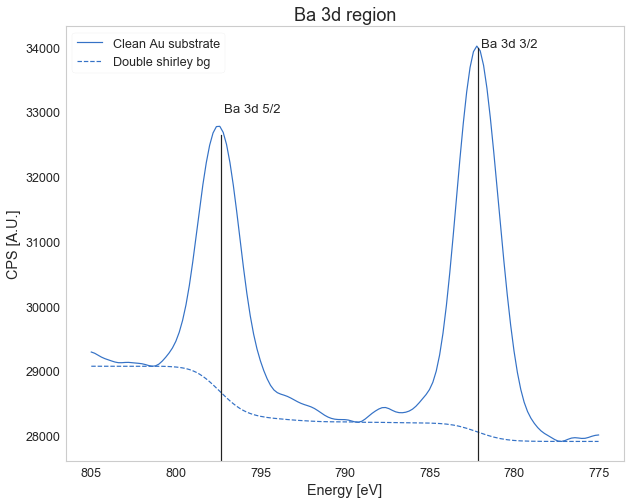

In [263]:
fig = plt.figure(figsize=(10, 8))
Drop.__init__(file_drop, lb[0])
Drop.gaussian_smooth(region)
Drop.subtract_double_shirley(region, 789.2)
# plt.legend(loc='center left', framealpha=0.1)
plt.axvline(x = fits_ba[1][1], ymax = 0.75, color='k')
plt.text(s = 'Ba 3d 5/2', x = fits_ba[1][1] - 0.2, y = 33e3)
plt.axvline(x = fits_ba[1][4], ymax = 0.95, color='k')
plt.text(s = 'Ba 3d 3/2', x = fits_ba[1][4] - 0.2, y = 34e3)

plt.title('Ba 3d region', fontsize = 18)

In [277]:
fits_ba[1][4] - fits_ba[1][1]

-15.20874732497748

### All measurements

Text(0.5, 1.0, 'Ba 3d region')

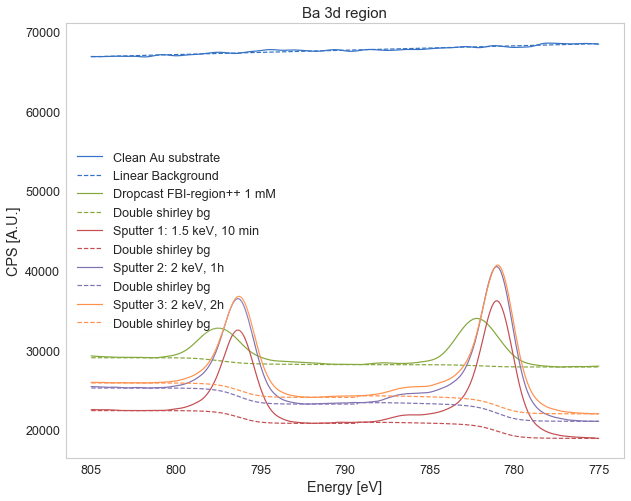

In [17]:
fig = plt.figure(figsize=(10, 8))

for j, d in enumerate(data):
    d.gaussian_smooth(region)
    if j == 0:
        d.subtract_linear_bg(region)
    else:
        d.subtract_double_shirley(region, 789.2)
plt.legend(loc='center left', framealpha=0.1)
plt.title('Ba 3d region', fontsize = 15)

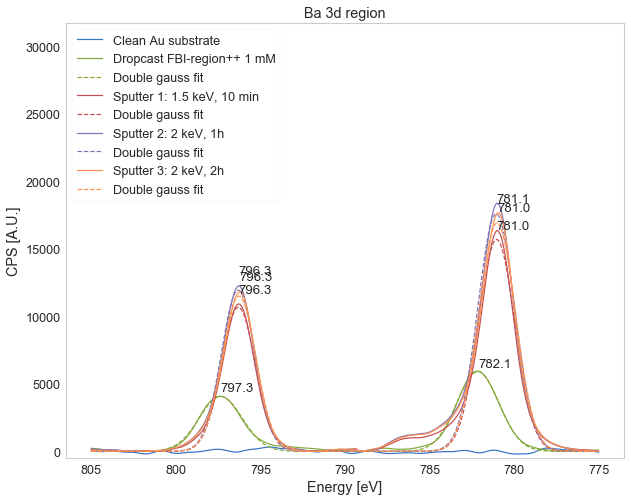

In [18]:
fig = plt.figure(figsize=(10, 8))
fits_ba = []
for j, d in enumerate(data):
#     d.plot_region(region, lb = lb[j])
    if j == 0:
        d.plot_region(region)
    else:
        fits_ba.append(d.fit_double_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left')
# plt.gca().invert_xaxis()

### Integrate areas

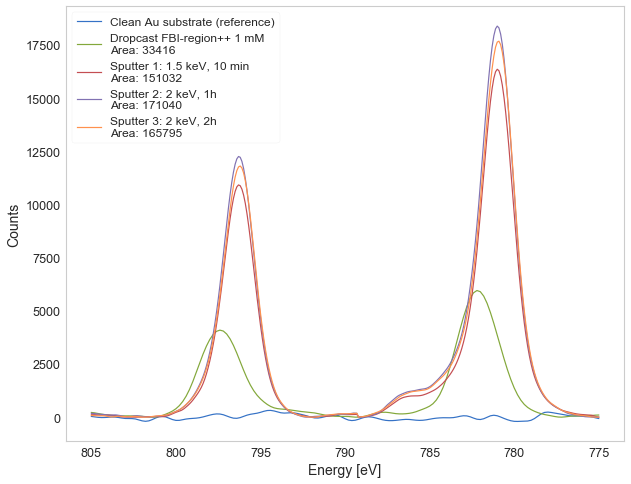

In [19]:
plt.figure(figsize=(10, 8))
data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_ba = []
for j, d in enumerate(data[1:]):
    area_ba.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j+1]))

Text(0.5, 1.0, 'Sputter effect')

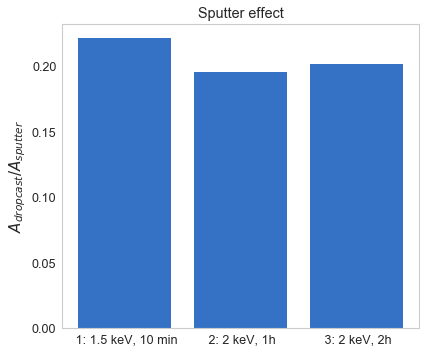

In [20]:
sput_eff = [area_ba[1]/area_ba[0], area_ba[2]/area_ba[0], area_ba[3]/area_ba[0]]
plt.bar([s.replace('Sputter','') for s in lb[2:]], [1/x for x in sput_eff])
plt.ylabel('$A_{dropcast}/A_{sputter}$', fontsize=15)
plt.title('Sputter effect')

In [314]:
for j, d in enumerate(data):
    x = d.df[region].dropna().energy
    y = d.df[region].dropna().counts

    yl, yr = y [ x < 790 ], y [ x >= 790]

    step = x[0] - x[1]
    Sl = np.trapz(yl, dx= step)
    Sr = np.trapz(yr, dx= step)
    print(Sr/Sl, 2/3)

-1.0192025003507124 0.6666666666666666
0.7261069017668429 0.6666666666666666
0.585594984388667 0.6666666666666666
0.578689784066465 0.6666666666666666
0.5798190528710228 0.6666666666666666


### Shake-up peak

In [333]:
def V(x, amp, sigma, gamma,a,b):
    """ Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component sigma, a&b as the center. """
    
    return amp*np.exp(-(x-a)**2/(2*(sigma)**2))+gamma/np.pi/((x-b)**2+(gamma)**2)

11.572191639016078


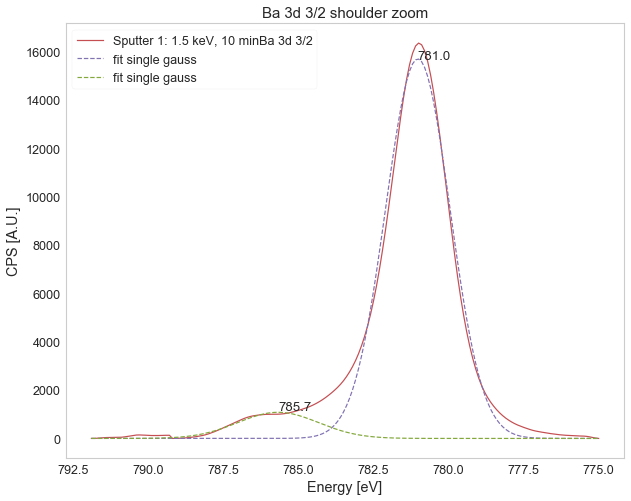

In [370]:
plt.figure(figsize=(10,8))
x = Sput1.df[region].dropna().energy
y = Sput1.df[region].dropna().counts
y = y[ x < 792]
x = np.array(x[ x < 792])
plt.plot(x, y, '-r', label=Sput1.name + 'Ba 3d 3/2')

step = x[-2] - x[-1]
fitv, covv = curve_fit(Sput1.gauss, x, y, p0 = [15000, 789, 2])
yfitv = Sput1.gauss(x, *fitv)
plt.plot(x, yfitv, 'm--', label='fit single gauss')

area_big = np.trapz(yfitv, dx = step)

yp = y[x > 785]
xp = x[x > 785]
fitg, covv = curve_fit(Sput1.gauss, xp, yp, p0 = [1000, 787, 1])
yfitg = Sput1.gauss(x, *fitg)
plt.plot(x, yfitg, 'g--', label='fit single gauss')
area_small = np.trapz(yfitg, dx = step)

print(area_big/ area_small)
plt.text(s='%.1f'%fitv[1], x=fitv[1], y=fitv[0]*1.0)
plt.text(s='%.1f'%fitg[1], x=fitg[1], y=fitg[0]*1.1)
plt.title('Ba 3d 3/2 shoulder zoom', fontsize = 15)

Sput1.cosmetics_plot()

### Voigt fit

11.572191639016078


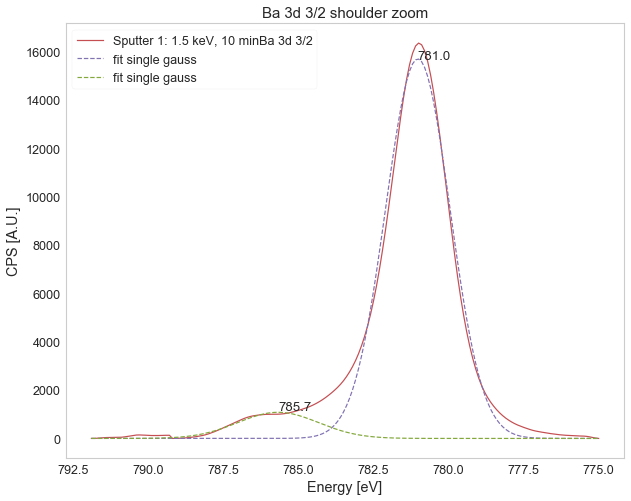

In [370]:
from lmfit.models import PseudoVoigtModel, GaussianModel

x, y = Drop.df[region].dropna().energy, Drop.df[region].dropna().counts
y = y[ x < 792]
x = np.array(x[ x < 792])
plt.plot(x, y, '-b', label=Sput1.name + 'Ba 3d 3/2')

mod = PseudoVoigtModel(prefix='v_')
pars = mod.guess(y, x=x)
pars['v_sigma'].set(value=1)
fitv = mod.fit(y, pars, x=x)
# print(fitv.fit_report(min_correl=0.25))
fitpar = [ fitv.best_values[i] for i in fitv.best_values]
plt.plot(x, fitv.best_fit, '-r', label='Fit')

step = x[-2] - x[-1]
fitv, covv = curve_fit(Sput1.gauss, x, y, p0 = [15000, 789, 2])
yfitv = Sput1.gauss(x, *fitv)
plt.plot(x, yfitv, 'm--', label='fit single gauss')

area_big = np.trapz(yfitv, dx = step)

yp = y[x > 785]
xp = x[x > 785]
fitg, covv = curve_fit(Sput1.gauss, xp, yp, p0 = [1000, 787, 1])
yfitg = Sput1.gauss(x, *fitg)
plt.plot(x, yfitg, 'g--', label='fit single gauss')
area_small = np.trapz(yfitg, dx = step)

print(area_big/ area_small)
plt.text(s='%.1f'%fitv[1], x=fitv[1], y=fitv[0]*1.0)
plt.text(s='%.1f'%fitg[1], x=fitg[1], y=fitg[0]*1.1)
plt.title('Ba 3d 3/2 shoulder zoom', fontsize = 15)

Sput1.cosmetics_plot()

## C

In [34]:
region = 'C_1s'

Text(0.5, 1.0, 'C 1s region')

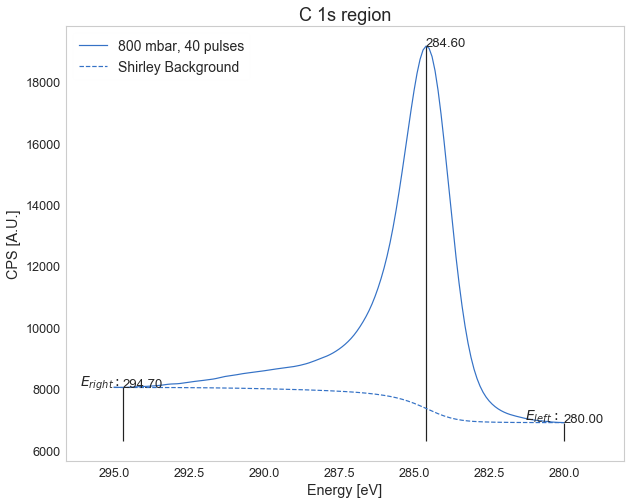

In [10]:
fig = plt.figure(figsize=(10, 8))
Sput1.__init__(file_sput1, lb[2])
Sput1.gaussian_smooth(region)
Sput1.subtract_shirley_bg(region)
plt.legend(loc='upper left', framealpha=0.1, fontsize = 14)

plt.text(s = '$E_{right}: $', x = 294.8 , y = 8.1e3, ha='right', fontsize=14)
plt.text(s = '$E_{left}: $', x = 280.2 , y = 7.0e3, ha='right', fontsize=14)

plt.xlim(296.6, 278)
plt.title('C 1s region', fontsize = 18)

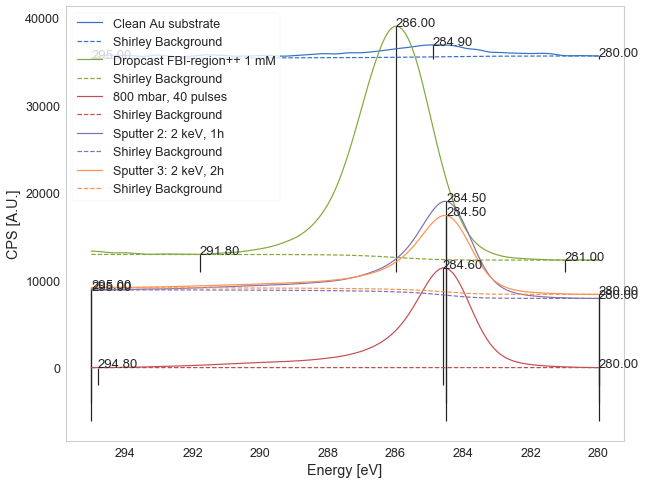

In [11]:
plt.figure(figsize=(10,8))
for j, d in enumerate(data):
    d.gaussian_smooth(region)
    d.subtract_shirley_bg(region)
# plt.gca().invert_xaxis()

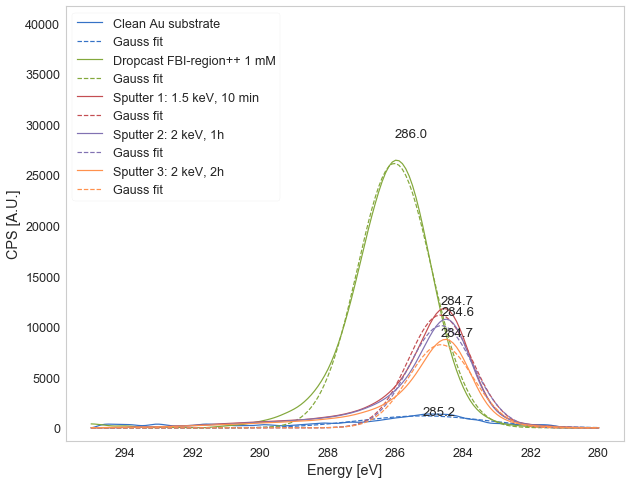

In [29]:
fig = plt.figure(figsize=(10, 8))
fits_c = []
for j, d in enumerate(data):
    fits_c.append(d.fit_gauss(region))
yl = plt.ylim()
plt.ylim(yl[0], yl[1]*1.5)
plt.gca().invert_xaxis()

### Fit to Voigt function (work in progress)

#### Preliminar fit to PseudoVoigt

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/lmfit/models.py:34: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return np.abs(arr-val).argmin()


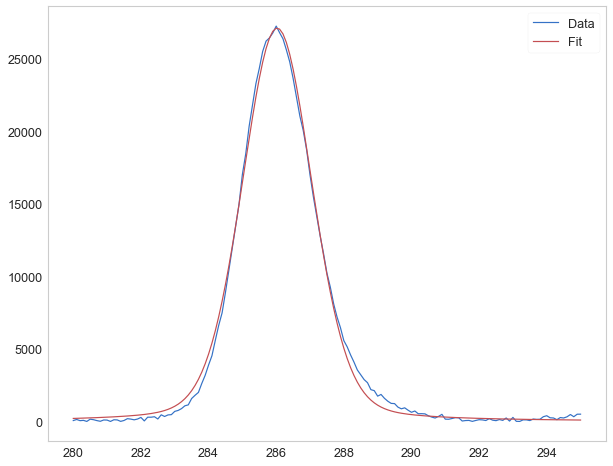

In [35]:
from lmfit.models import PseudoVoigtModel, GaussianModel
fig = plt.figure(figsize=(10, 8))
Drop.__init__(file_drop, lb[2])
# Drop.gaussian_smooth(region)
Drop.subtract_shirley_bg(region)
plt.clf()

x, y = Drop.df[region].dropna().energy, Drop.df[region].dropna().counts
plt.plot(x, y, '-b', label='Data')

mod = PseudoVoigtModel(prefix='v_')
pars = mod.guess(y, x=x)
pars['v_sigma'].set(value=1)
fitv = mod.fit(y, pars, x=x)
# print(fitv.fit_report(min_correl=0.25))
fitpar = [ fitv.best_values[i] for i in fitv.best_values]
plt.plot(x, fitv.best_fit, '-r', label='Fit')
plt.legend()
# fitv.plot()   # Plot includes residuals

#### Voigt + Gaussian

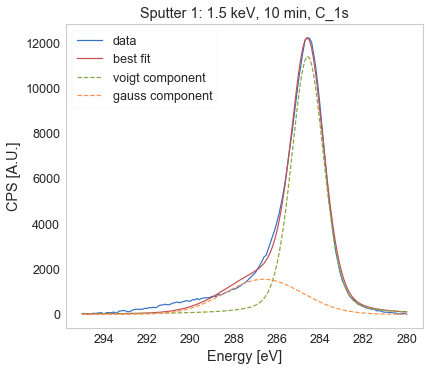

In [89]:
gauss2 = GaussianModel(prefix='g_')
pars.update(gauss2.make_params())

pars['g_center'].set(value=287, min=286, max=288)
pars['g_sigma'].set(value=1, min=0.8, max=1.8)
pars['g_amplitude'].set(value=6000, min=4000, max=7000)

mod2 = mod + gauss2

init = mod2.eval(pars, x = x)
fitvg = mod2.fit(y, pars, x=x)
# print(fitvg.fit_report(min_correl=.5))
comps = fitvg.eval_components(x=x)
plt.plot(x, y, 'b', label='data')
plt.plot(x, fitvg.best_fit, '-r', label = 'best fit')
plt.plot(x, comps['v_'], 'g--', label = 'voigt component')
plt.plot(x, comps['g_'], 'y--', label = 'gauss component')
plt.title(Sput1.name+', '+region)
Drop.cosmetics_plot()

In [26]:
def fit_voigt_gauss(df : pd.DataFrame, par_g : list, bounds_g: list, ax, flag_plot : bool = False):
    from lmfit.models import PseudoVoigtModel, GaussianModel

    x, y = df.dropna().energy, df.dropna().counts
    ax.plot(x, y, '-b', label='Data')

    mod = PseudoVoigtModel(prefix='v_')
    pars = mod.guess(y, x=x)
    pars['v_sigma'].set(value=1)
    fitv = mod.fit(y, pars, x=x)
    # print(fitv.fit_report(min_correl=0.25))
    fitpar = [ fitv.best_values[i] for i in fitv.best_values]
    if flag_plot:
        ax.plot(x, fitv.best_fit, '--r', label='Fit to single Voigt')
        
    gauss2 = GaussianModel(prefix='g_')
    pars.update(gauss2.make_params())

    pars['g_center'].set(value = par_g[0], min=bounds_g[0][0], max=bounds_g[0][1])
    pars['g_sigma'].set(value = par_g[1], min=bounds_g[1][0], max=bounds_g[1][1])
    pars['g_amplitude'].set(value = par_g[2], min=bounds_g[2][0], max=bounds_g[2][1])

    mod2 = mod + gauss2

    init = mod2.eval(pars, x = x)
    fitvg = mod2.fit(y, pars, x=x)
    # print(fitvg.fit_report(min_correl=.5))
    comps = fitvg.eval_components(x=x)
    # a1, a0 = [compute_area(fitvg, prefix) for prefix in ['g_', 'v_']]

    ax.plot(x, fitvg.best_fit, '-r', label = 'best fit')
    ax.plot(x, comps['v_'], 'g--', label = 'voigt component @ %.2f \nArea ref. '%fitvg.best_values['v_center'])
    ax.plot(x, comps['g_'], 'y--', label = '1st gauss component @ %.2f \nArea = %.2f*Area_ref '%(fitvg.best_values['g_center']))#, a1/a0))

    return fitvg

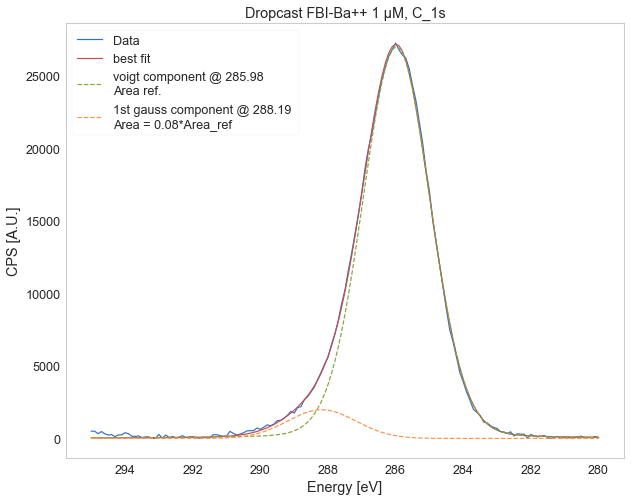

In [150]:
fig = plt.figure(figsize=(10, 8))
Drop.__init__(file_drop, lb[2])
# Drop.gaussian_smooth(region)
Drop.subtract_shirley_bg(region)
plt.clf()
ax = plt.gca()
fit0 = fit_voigt_gauss(Drop.df[region], par_g=[287, 1, 2e4], bounds_g=[(286, 292), (0.8, 1.8), (1e3, 5e3)], ax = ax)
ax.set_title('Dropcast FBI-Ba++ 1 µM, '+region)
Drop.cosmetics_plot()

In [103]:
fit0.best_values['g_center']

288.1850959060921

#### Voigt + 2 gaussian

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/lmfit/models.py:34: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return np.abs(arr-val).argmin()


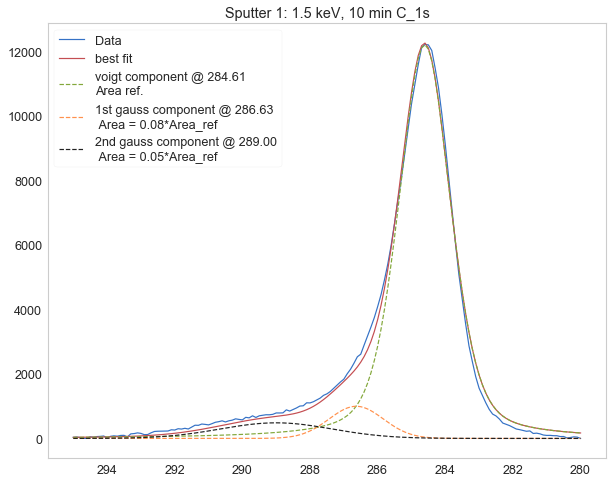

In [144]:
from lmfit.models import PseudoVoigtModel, GaussianModel
fig, ax = plt.subplots(figsize=(10,8))
x, y = Sput1.df[region].dropna().energy, Sput1.df[region].dropna().counts
ax.plot(x, y, '-b', label='Data')

mod = PseudoVoigtModel(prefix='v_')
pars = mod.guess(y, x=x)
pars['v_sigma'].set(value=1)
fitv = mod.fit(y, pars, x=x)
# print(fitv.fit_report(min_correl=0.25))
fitpar = [ fitv.best_values[i] for i in fitv.best_values]
# if flag_plot:
#     ax.plot(x, fitv.best_fit, '--r', label='Fit to single Voigt')

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(value = 287, min=286 , max= 288)
pars['g1_sigma'].set(value = 1.2, min=0.8, max=2.3)
pars['g1_amplitude'].set(value = 1800, min=500, max=2000)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value = 290, min=289, max=292)
pars['g2_sigma'].set(value = 1.2, min=0.8, max=2.5)
pars['g2_amplitude'].set(value = 1000, min=500, max=2e3)

mod2 = mod + gauss1 + gauss2

init = mod2.eval(pars, x = x)
fitvg = mod2.fit(y, pars, x=x)
# print(fitvg.fit_report(min_correl=.5))
comps = fitvg.eval_components(x=x)

def compute_area(fit, prefix):
    sigma = fit.best_values[prefix+'sigma']
    amp = fit.best_values[prefix+'amplitude']
    return amp * np.sqrt(np.pi/sigma)
a1, a2, a0 = [compute_area(fitvg, prefix) for prefix in ['g1_', 'g2_', 'v_']]
ax.plot(x, fitvg.best_fit, '-r', label = 'best fit')
ax.plot(x, comps['v_'], 'g--', label = 'voigt component @ %.2f \nArea ref. '%fitvg.best_values['v_center'])
ax.plot(x, comps['g1_'], 'y--', label = '1st gauss component @ %.2f \nArea = %.2f*Area_ref '%(fitvg.best_values['g1_center'], a1/a0))
ax.plot(x, comps['g2_'], 'k--', label = '2nd gauss component @ %.2f \nArea = %.2f*Area_ref'%(fitvg.best_values['g2_center'], a2/a0))
ax.legend()
ax.set_title(Sput1.name+' '+region)
ax.invert_xaxis()

In [143]:
prefix = 'g1_'
fitvg.best_values[prefix+'sigma']
def compute_area(fit, prefix):
    sigma = fit.best_values[prefix+'sigma']
    amp = fit.best_values[prefix+'amplitude']
    return amp * np.sqrt(np.pi/sigma)
(compute_area(fitvg, prefix), compute_area(fitvg, 'g2_'))/ compute_area(fitvg, 'v_')

array([0.07677848, 0.05348889])

In [62]:
fitvg[1]

### Fit to double gaussian

In [21]:
def gauss(x, N, mu, s):
    return N* np.exp( -(x - mu)**2/( 2* s**2) )
def double_gauss(x, *par):
#     print(*par[:3])
    return gauss(x, *par[:3]) + gauss(x, *par[3:])

In [52]:
Drop.__init__(file_drop, lb[2])
# Drop.gaussian_smooth(region)
Drop.subtract_shirley_bg(region)
plt.clf()

plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'width_ratios': [3,1]})

x, y = Drop.df[region].dropna().energy, Drop.df[region].dropna().counts
p0 = [25000, 286, 0.5, 25000, 287.6, 0.5]

ax[0].plot(x, y, '-b', label='Data')
# fitv, covv = curve_fit(gauss, x, y, p0 = p0[:3])
# ax[0].plot(x, gauss(x, *fitv), '-g', label='Fit single gauss')

fitv2, covv = curve_fit(double_gauss, x, y, p0 = p0)
yfit = double_gauss(x, *fitv2)
res = y - yfit

ax[0].plot(x, yfit, 'r', label='Fit double gauss')

ygauss1, ygauss2 = gauss(x, *fitv2[:3]), gauss(x, *fitv2[3:])
ax[0].plot(x, ygauss1, "y", label = '$\\mu = %.1f, \\sigma = %.1f $' %(fitv2[1], fitv2[2]))
ax[0].plot(x, ygauss2, "g", label = '$\\mu = %.1f, \\sigma = %.1f $' %(fitv2[4], fitv2[5]))

ax[0].fill_between(x, ygauss1.min(), ygauss1, facecolor="yellow", alpha=0.5)  
ax[0].fill_between(x, ygauss2.min(), ygauss2, facecolor="g", alpha=0.5)  
ax[0].legend(loc='upper right')

ax[1].plot(x, res, 'o')
fitv2

ValueError: Expected the given number of width ratios to match the number of columns of the grid

<Figure size 460.8x403.2 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 460.8x403.2 with 0 Axes>

In [68]:
type(Drop)

xps.xps_sw.XPSana

In [28]:
def double_gauss_fit(data : XPSana, p0 : list, region : str, ax):

    x, y = data.df[region].dropna().energy, data.df[region].dropna().counts

    ax[0].plot(x, y, '-b', label='Data')
    # fitv, covv = curve_fit(gauss, x, y, p0 = p0[:3])
    # ax[0].plot(x, gauss(x, *fitv), '-g', label='Fit single gauss')

    fitv2, covv = curve_fit(double_gauss, x, y, p0 = p0)
    yfit = double_gauss(x, *fitv2)
    res = y - yfit

    ax[0].plot(x, yfit, 'r', lw=2, label='Fit double gauss')

    ygauss1, ygauss2 = gauss(x, *fitv2[:3]), gauss(x, *fitv2[3:])
    ax[0].plot(x, ygauss1, "y", label = '$\\mu = %.1f, \\sigma = %.1f $' %(fitv2[1], fitv2[2]))
    ax[0].plot(x, ygauss2, "g", label = '$\\mu = %.1f, \\sigma = %.1f $' %(fitv2[4], fitv2[5]))

    ax[0].fill_between(x, ygauss1.min(), ygauss1, facecolor="yellow", alpha=0.5)  
    ax[0].fill_between(x, ygauss2.min(), ygauss2, facecolor="g", alpha=0.5)  
    ax[0].set_ylabel('Counts')
    ax[0].legend(loc='upper right')
    
    ax[1].plot(x, res, 'o')
    ax[1].set_xlabel('Energy [eV]')
    ax[1].set_ylabel('Fit residuals')
    print(np.sum(res))
    return fitv2

### Systematic fit

<Figure size 460.8x403.2 with 0 Axes>

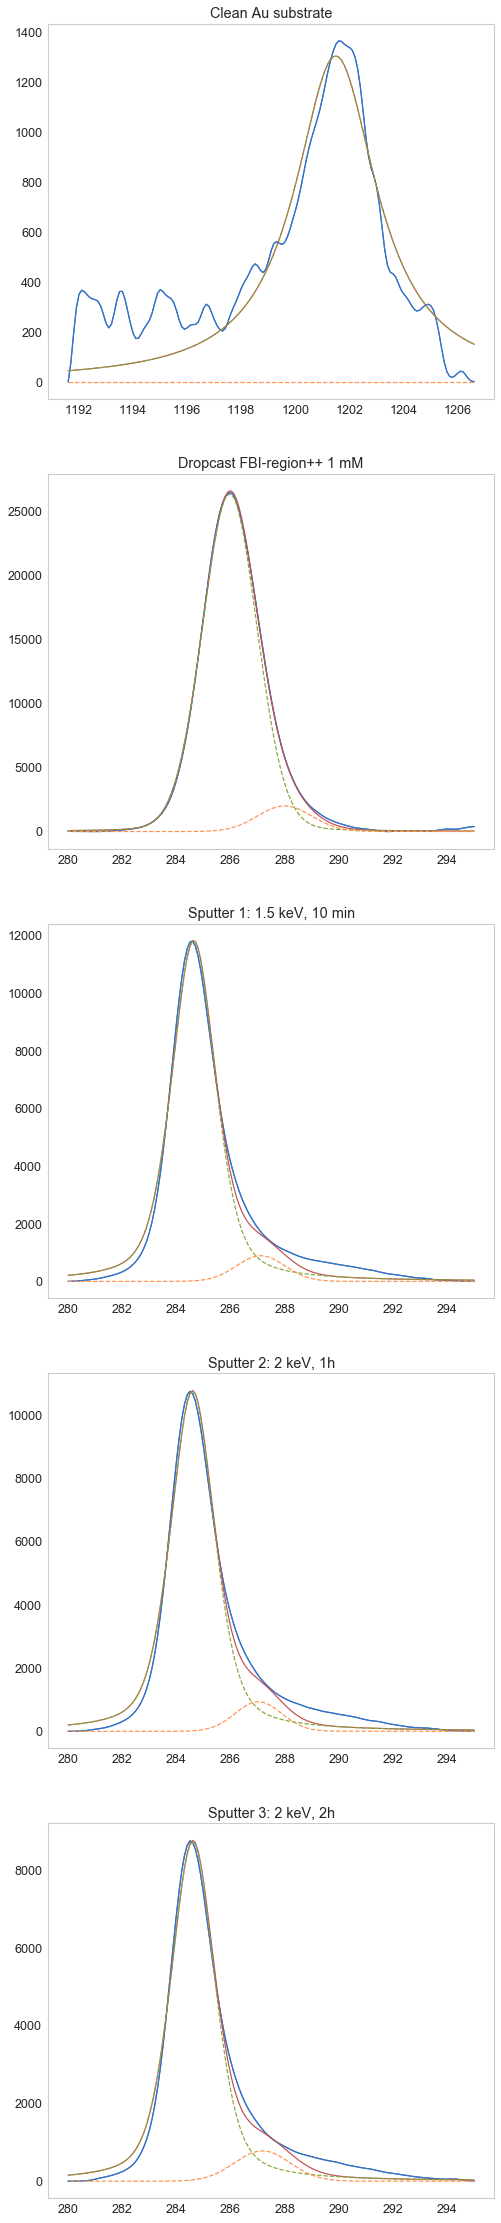

In [71]:
p0 = [25000, 286, 0.5, 25000, 287.6, 0.5]
for j, d in enumerate(data):
    d.__init__(files[j], lb[j])
    d.gaussian_smooth(region)
    d.subtract_shirley_bg(region)
    plt.clf()

fig, ax = plt.subplots(len(data))
fitvg = []

for j, d in enumerate(data):
    if j == 1:
        fitvg.append( fit_voigt_gauss(d.df[region], par_g=[287, 1, 2e3], bounds_g=[(286, 288), (0.8, 1.8), (2e3, 5e3)], ax=ax[j]) )
    else:
        fitvg.append( fit_voigt_gauss(d.df[region], par_g=[288, 1, 1000], bounds_g=[(286, 289), (0.8, 2.3), (500, 2e3)], ax=ax[j]) )
    
    ax[j].set_title(d.name)
fig.set_figheight(len(data)*8)
fig.set_figwidth(8*1)

#### Integrate areas

In [112]:
def compute_area(fit : list, cov : list) -> list:
    area =  fit[0] * np.sqrt(np.pi/fit[2])
    uarea1 = np.sqrt(cov[0,0]) * np.sqrt(np.pi/fit[2])
    uarea2 = fit[0] * np.sqrt(np.pi/2/fit[2]**3)
    return area, np.sqrt(uarea1**2 + uarea2**2)

In [114]:
area, uarea = compute_area(fitv2, covv)

NameError: name 'covv' is not defined

##### Better analytical integration

In [60]:
names = ['amplitude_1', 'mu_1', 'sigma_1', 'amplitude_2', 'mu_2', 'sigma_2']

for i, p in enumerate(fitv2):
    print('%s: %.2f +- %.2f' %(names[i], p, np.sqrt(covv[i][i])))
    

amplitude_1: 22999.49 +- 425.27
mu_1: 285.93 +- 0.01
sigma_1: 0.95 +- 0.01
amplitude_2: 4771.95 +- 402.85
mu_2: 286.80 +- 0.08
sigma_2: 1.60 +- 0.03


In [ ]:
3644, 375, 2489, 212, 3240.000

In [ ]:
36644, 375, 2489, 212, 3240

### Integrate areas

Text(0.5, 1.0, 'C 1s')

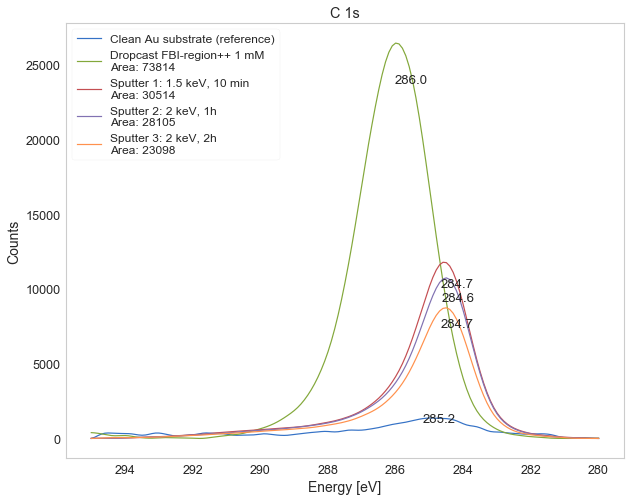

In [30]:
plt.figure(figsize=(10, 8))
data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_c = []
for j, d in enumerate(data[1:]):
    area_c.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j+1]))
    plt.text(s='%.1f'%fits_c[j][1], x = fits_c[j][1], y = fits_c[j][0]*0.91)
plt.text(s='%.1f'%fits_c[4][1], x = fits_c[4][1], y = fits_c[4][0]*0.91)

plt.title('C 1s')

Text(0.5, 1.0, 'Sputter effect')

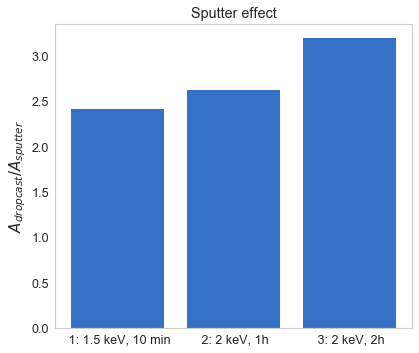

In [31]:
sput_eff = [area_c[1]/area_c[0], area_c[2]/area_c[0], area_c[3]/area_c[0]]
plt.bar([s.replace('Sputter','') for s in lb[2:]], [1/x for x in sput_eff])
plt.ylabel('$A_{dropcast}/A_{sputter}$', fontsize=15)
plt.title('Sputter effect')

## O

In [34]:
region = 'O_1s'

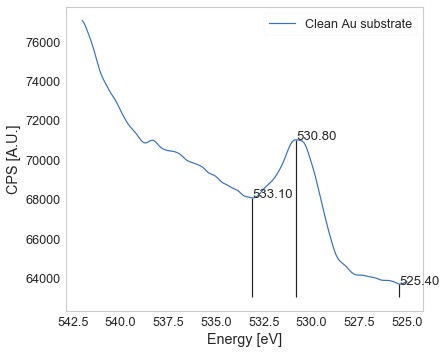

In [35]:
Clean.gaussian_smooth(region)
Clean.plot_region(region)
x, y = Clean.df[region].dropna().energy, Clean.df[region].dropna().counts
x, y, _ = Clean.check_arrays(x, y)
y = y [x < 538]
x = x [x < 538]
dfnew = pd.DataFrame({'energy': x, 'counts' : y})
Clean.find_integration_limits(x, y, flag_plot=True)
Clean.df[region] = dfnew

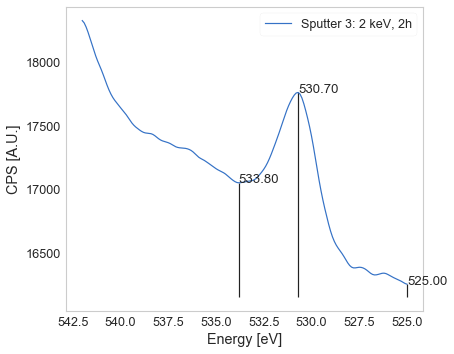

In [36]:
Sput3.gaussian_smooth(region)
Sput3.plot_region(region)
x, y = Sput3.df[region].dropna().energy, Sput3.df[region].dropna().counts
x, y, _ = Sput3.check_arrays(x, y)
y = y [x < 538]
x = x [x < 538]
dfnew = pd.DataFrame({'energy': x, 'counts' : y})
Sput3.find_integration_limits(x, y, flag_plot=True)
Sput3.df[region] = dfnew

Clean Au substrate
specs.shirley_calculate: Max iterations exceeded before convergence.
Dropcast FBI-region++ 1 mM
Sputter 1: 1.5 keV, 10 min
Sputter 2: 2 keV, 1h
specs.shirley_calculate: Max iterations exceeded before convergence.
Sputter 3: 2 keV, 2h
specs.shirley_calculate: Max iterations exceeded before convergence.


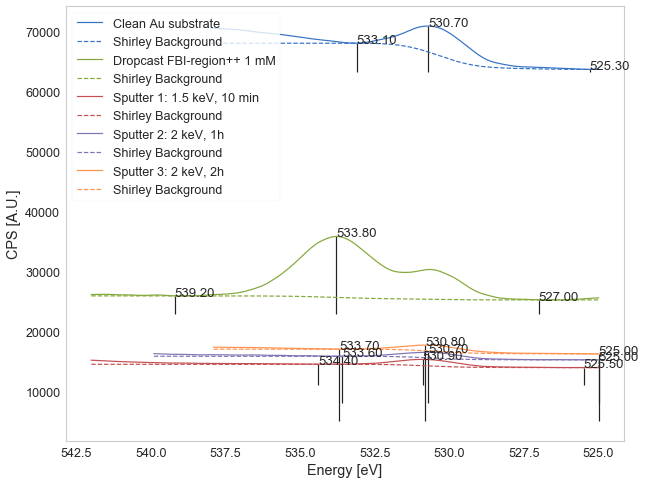

In [37]:
plt.figure(figsize=(10, 8))
for j, d in enumerate(data):
    d.gaussian_smooth(region)
    if j == 0: 
        d.df[region] = d.df[region][d.df[region]['energy'] < 538]
    elif j >= 3:
        d.df[region] = d.df[region][d.df[region]['energy'] < 540]
        
    print(lb[j])
#     x, y = d.df[region].energy, d.df[region].counts
    d.subtract_shirley_bg(region, lb = lb[j], )
#     ybg = d.shirley_loop(x, y, lmidx = 21, rmidx = 168 )
#     d.plot_region(region, lb = lb[j])
#     plt.plot(x, ybg, '--')

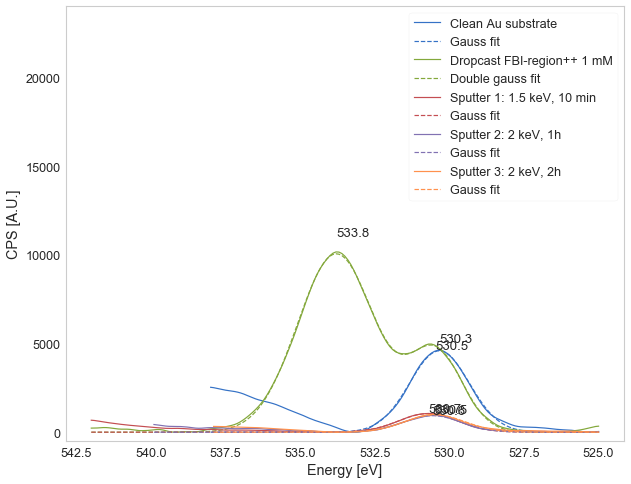

In [38]:
fig = plt.figure(figsize=(10, 8))
fits_o = []
for j, d in enumerate(data):
    if j == 1:
        fits_o.append(d.fit_double_gauss(region, lb=lb[j]))
    else:
        fits_o.append(d.fit_gauss(region, lb=lb[j]))
yl = plt.ylim()
plt.ylim(yl[0], yl[1]*1.5)
plt.gca().invert_xaxis()

### Integrate areas

Text(0.5, 1.0, 'O 1s region')

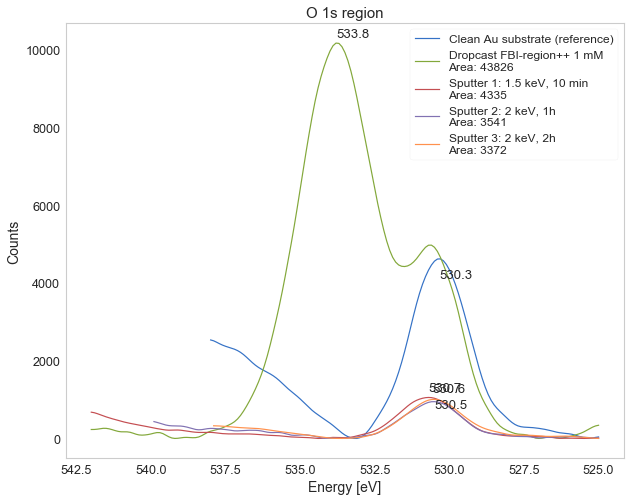

In [39]:
plt.figure(figsize=(10, 8))
data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_o = []
for j, d in enumerate(data[1:]):
    area_o.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j+1]))
    plt.text(s='%.1f'%fits_o[j][1], x = fits_o[j][1], y = fits_o[j][0]*(0.9+j/8))
plt.text(s='%.1f'%fits_o[4][1], x = fits_o[4][1], y = fits_o[4][0]*0.8)
plt.title('O 1s region', fontsize=15)

Text(0.5, 1.0, 'Sputter effect')

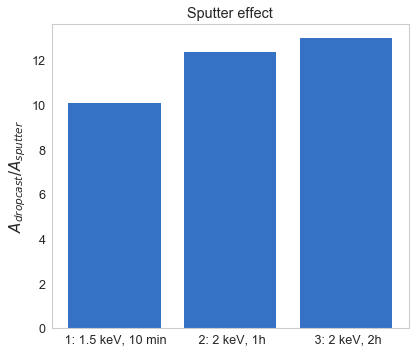

In [41]:
sput_eff = [area_o[1]/area_o[0], area_o[2]/area_o[0], area_o[3]/area_o[0]]
plt.bar([s.replace('Sputter','') for s in lb[2:]], [1/x for x in sput_eff])
plt.ylabel('$A_{dropcast}/A_{sputter}$', fontsize=15)
plt.title('Sputter effect')

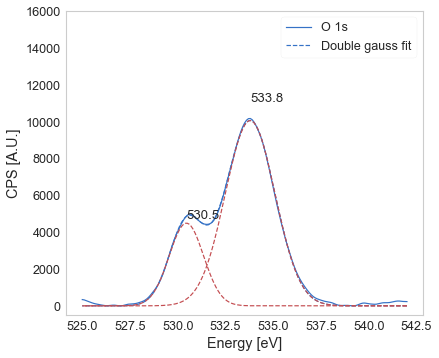

In [9]:
fit = Drop.fit_double_gauss(region, )
x = Drop.df.O_1s.dropna().energy.values
y1 = Drop.gauss(x, *fit[:3])
y2 = Drop.gauss(x, *fit[3:])
plt.plot(x, y1, '--r')
plt.plot(x, y2, '--r')

## Cl

In [46]:
region = 'Cl_2p'

specs.shirley_calculate: Max iterations exceeded before convergence.


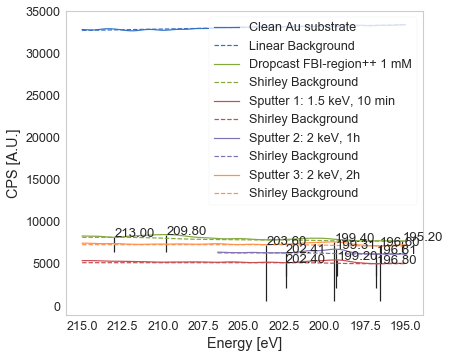

In [47]:
for j, d in enumerate(data):
    d.gaussian_smooth(region, sigma = 4)
    if j == 0:
        d.subtract_linear_bg(region)
    else:
        d.subtract_shirley_bg(region, )

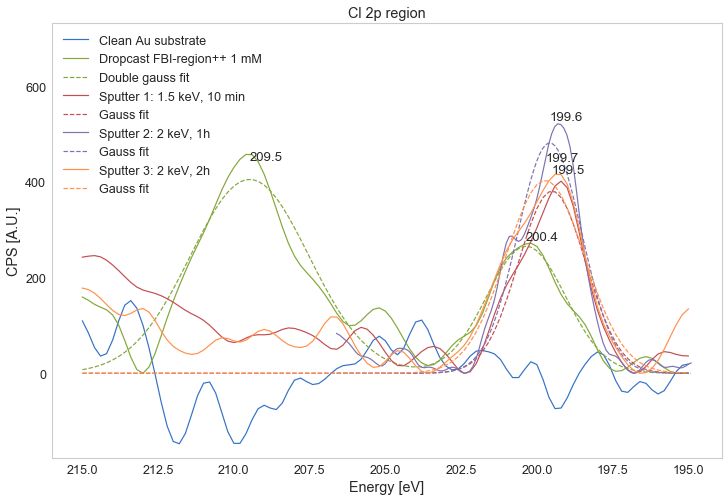

In [48]:
fig = plt.figure(figsize=(12, 8))
fits_cl = []
for j, d in enumerate(data):
#     d.plot_region(region, lb = lb[j])
    if j == 0:
        d.plot_region(region)
    elif j == 1:
        fits_cl.append(d.fit_double_gauss(region))
    else:
        fits_cl.append(d.fit_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left', framealpha=0.)
# plt.gca().invert_xaxis()

In [554]:
fits_cl

[array([361.55976992, 209.37082411,   1.79306915, 231.17698519,
        200.30045086,   1.37615583]),
 array([318.58383303, 199.49904566,   1.13388011]),
 array([458.43846024, 199.58606457,   1.06954957]),
 array([352.03269564, 199.75604572,   1.32122139])]

Text(0.5, 1.0, 'Cl 2p')

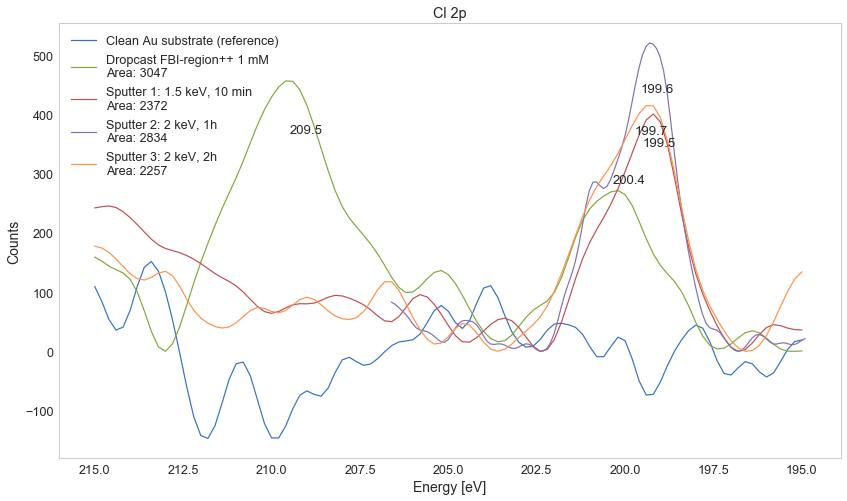

In [49]:
plt.figure(figsize=(14, 8))
data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_cl = []
for j, d in enumerate(data[1:]):
    area_cl.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j+1]))
    plt.text(s='%.1f'%fits_cl[j][1], x = fits_cl[j][1], y = fits_cl[j][0]*0.91)

plt.text(s='%.1f'%fits_cl[0][4], x = fits_cl[0][4], y = fits_cl[0][0]*0.7)

plt.legend(loc='upper left', framealpha=0.)
plt.title('Cl 2p')

## Summary

In [83]:
fits_ba.insert(0, [np.nan for i in range(5)])

In [85]:
for el, ba, c, o in zip(lb, fits_ba, fits_c, fits_o):
    print('| ' + el + '| %.1f | %.1f | %.1f | %.1f |'%(ba[1], ba[4], c[1], o[1]))

| Clean Au substrate| nan | nan | 285.2 | 530.3 |
| Dropcast FBI-region++ 1 mM| 797.3 | 782.1 | 286.0 | 533.8 |
| Sputter 1: 1.5 keV| 796.3 | 781.0 | 284.7 | 530.7 |
| Sputter 2: 2 keV 1h| 796.3 | 781.1 | 284.6 | 530.6 |
| Sputter 3: 2 keV 2h| 796.3 | 781.0 | 284.7 | 530.5 |


| Core level |  Ba 3d 3/2  |  Ba 3d 5/2 |  C 1s  |  O 1s  |
|----------|:-------------:| :------: | :------: | ----------:|
| Clean Au substrate| nan | nan | 285.2 | 530.3 |
| Dropcast FBI-region++ 1 mM| 797.3 | 782.1 | 286.0 | 533.8 |
| Sputter 1: 1.5 keV| 796.3 | 781.0 | 284.7 | 530.7 |
| Sputter 2: 2 keV 1h| 796.3 | 781.1 | 284.6 | 530.6 |
| Sputter 3: 2 keV 2h| 796.3 | 781.0 | 284.7 | 530.5 |

In [90]:
fits_ba[1]

array([4.06265574e+03, 7.97345086e+02, 1.27416443e+00, 5.91317247e+03,
       7.82136339e+02, 1.24804533e+00])

##### From Moulder Handbook
| Compound | C 1s |  Compound  | O 1s | Compound |  Ba 3d 5/2 |  
|----------|:-------------:| :------: | :------: |  :------: | ----------:|
| Carbide | 282 $\pm$ 1 |  Metal oxides  |  529.5 $\pm$ 1.5  |  Ba |  780.2 $\pm$ 0.2 |
| Carbon | 284.5 $\pm$ 0.5 |  Hydroxides  |  531.5 $\pm$ 0.5 |  BaO  | 779.5 $\pm$ 0.3 |
| C-N | 286.5 $\pm$ 1.2 |  Nitrates  |  533.2 $\pm$ 0.5  | Ba(ClO$_4$)$_2$  | 780.9 (*) |
| C-O (alcohols) | 286.5 $\pm$ 0.4 |  Carbonates  |  531.0 $\pm$ 0.5 |
| C-O (ethers) | 287 $\pm$ 0.9 |  Chlorates  | 532.8 $\pm$ 0.2  |
| C-O (carboxyls) | 288.5 $\pm$ 0.5 | |
| C-O (carbonates) | 290.5 $\pm$ 1.2 | |
| C-Cl | 287.7 $\pm$ 1.2 | |

(*) J. Electron Spectrosc. Relat. Phenom. 56, 217 (1991)

In [164]:
ref_ba = [['Ba', 'BaO', 'Ba(ClO$_4$)$_2$'], [780.2, 779.5, 780.9], [0.2, 0.3, 0.2]]
ref_c = [['Carbide', 'C', 'C-N', 'C-O (alcohols)' , 'C-O (ethers)', 'C-O (carboxyls)', 'C-O (carbonates)', 'C-Cl'], 
        [282, 284.5, 286.5, 286.5, 287, 288.5, 290.5, 287.7],
        [1, 0.5, 1.2, 0.4, 0.9, 0.5, 1.2, 1.2]]
ref_o = [['Metal oxydes', 'Hydroxides', 'Nitrates', 'Carbonates', 'Chlorates'],
        [529.5, 531.5, 533.2, 531.0, 532.8], [1.5, 0.5, 0.5, 0.5, 0.2]]

Text(0.5, 0, 'Binding energy [eV]')

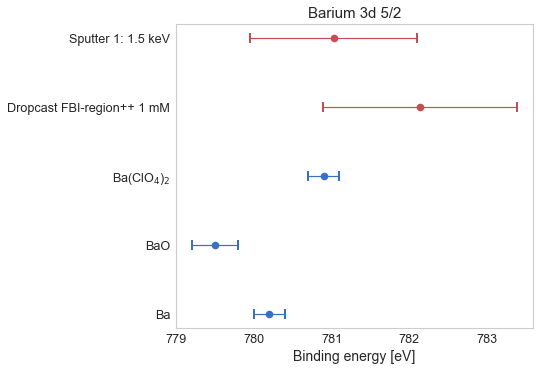

In [167]:
names, E, dE = ref_ba
plt.errorbar(x = E, xerr = dE, y = names, fmt='o', mew=2)
plt.errorbar(x = [ba[4] for ba in fits_ba[1:3]], xerr = [ba[5] for ba in fits_ba[1:3]], y = lb[1:3], fmt = 'ro')
plt.title('Barium 3d 5/2', fontsize = 15)
plt.xlabel('Binding energy [eV]', fontsize = 14)

#####  For dropcast measurement Ba is in reduced state +2, therefore the core level is shifted (1.1 eV) towards higher BE (harder to rip electrons)
This tells us that the coordinate bonding survives in this experiment
When the molecule is broken Barium is probably oxydized forming a similar bond as with perchlorates

Text(0.5, 0, 'Binding energy [eV]')

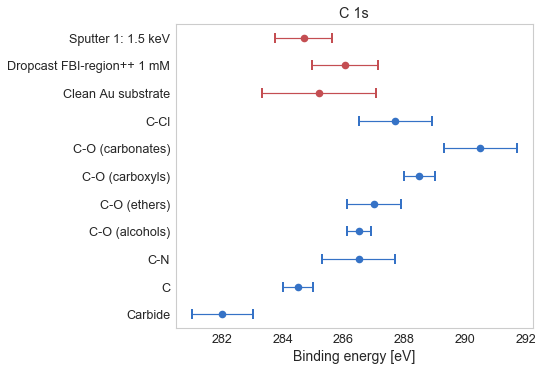

In [173]:
names, E, dE = ref_c
plt.errorbar(x = E, xerr = dE, y = names, fmt='o', mew=2)
plt.errorbar(x = [c[1] for c in fits_c[:3]], xerr = [c[2] for c in fits_c[:3]], y = lb[:3], fmt = 'ro')
plt.title('C 1s')
plt.xlabel('Binding energy [eV]', fontsize = 14)

##### For dropcast molecule Carbon appears as C-N bonding, so probably from solvent (CH$_3$CN)
When the molecule is broken, the main contribution comes from C-C bondings

Text(0.5, 0, 'Binding energy [eV]')

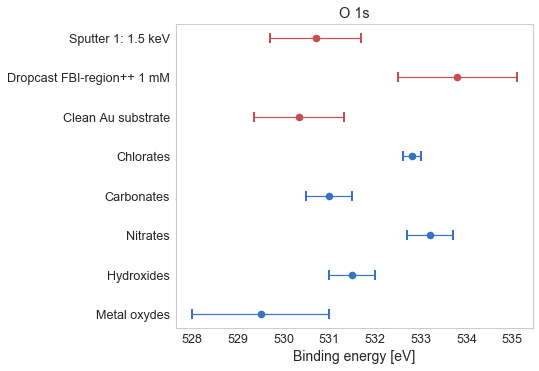

In [174]:
names, E, dE = ref_o
plt.errorbar(x = E, xerr = dE, y = names, fmt='o', mew=2)
plt.errorbar(x = [o[1] for o in fits_o[:3]], xerr = [o[2] for o in fits_o[:3]], y = lb[:3], fmt = 'ro')
plt.title('O 1s')
plt.xlabel('Binding energy [eV]', fontsize = 14)

##### Oxygen does not come from solvent, but there can be contamination on the gold
In the dropcast (intact) molecule it is shifted (3.1 eV) towards higher BE, as Barium is,
as these two elements are forming the coordinate bond

In [172]:
fits_ba[1][4] - fits_ba[2][4], fits_o[1][1] - fits_o[2][1]

(1.10923210624469, 3.086807960849228)

## Stechiometry

### Compare abundances
Need Atomic Sensitivity Factors (ASF) from handbook

In [518]:
area_ba

[33412.96485366881, 151028.39618314613, 171036.9809055853, 165792.00708512004]

In [519]:
area_c

[66823.88892310142, 23523.918158714223, 21114.7598302579, 16107.876931469842]

In [74]:
asf = [7.49, 0.296, 0.711, 0.770]
print('Relative abundance | C/Ba | O/Ba | C/O | Cl/Ba ')
for i in range(4):
    print('| ', lb[i+1], '| %.1f | %.1f | %.1f | %.1f |' %(area_c[i]*asf[0] / (area_ba[i]*asf[1])  , 
          area_o[i]*asf[0] / (area_ba[i]*asf[2]), 
          area_c[i]*asf[2] / (area_o[i]*asf[1]) , 
          area_cl[i]*asf[0] / (area_ba[i]*asf[3])) )

Relative abundance | C/Ba | O/Ba | C/O | Cl/Ba 
|  Dropcast FBI-region++ 1 mM | 55.9 | 13.8 | 4.0 | 0.9 |
|  Sputter 1: 1.5 keV, 10 min | 5.1 | 0.3 | 16.9 | 0.2 |
|  Sputter 2: 2 keV, 1h | 4.2 | 0.2 | 19.1 | 0.2 |
|  Sputter 3: 2 keV, 2h | 3.5 | 0.2 | 16.5 | 0.1 |


In [222]:
with open('../rel_abundances.csv', 'w') as fl:
    
    fl.write('Relative abundance ; C/Ba ; O/Ba ; C/O ; Cl/Ba \n')
    for i in range(4):
        fl.write(lb[i+1] + '; %.1f ; %.1f ; %.1f ; %.1f \n' %(area_c[i]*asf[0] / (area_ba[i]*asf[1])  ,
              area_o[i]*asf[0] / (area_ba[i]*asf[2]), 
              area_c[i]*asf[2] / (area_o[i]*asf[1]) , 
              area_cl[i]*asf[0] / (area_ba[i]*asf[3])))

# ALI series

### Import data

In [ ]:
path = '/Users/pabloherrero/sabat/xps_spectra/'
file800_20 = path + '2019_10_10_FBI_Au_mica/20191010_FBI_20puls_1uM_Au.xy'
file800_40 = path + '2019_10_10_FBI_Au_mica/20191010_FBI_40puls_1uM_Au.xy'
file800_ref = path + '2019_10_10_AcN_Au_mica/20191010_Au_111_clean.xy'

file200_ref = path + '2019_10_16_Au_crystal_FBI/20191016_Au(788)_clean.xy'
file200_40 = path + '2019_10_16_Au_crystal_FBI/20191016_FBI_FBI_Ba_1uM_40pulse_50ms_Au(788).xy'
file200_80 = path + '2019_10_17_Au_crystal/20191017_FBI_FBI_Ba_1uM_80pulse_50ms_Au(788).xy'
file200_120 = path + '2019_10_17_Au_crystal/20191017_FBI_FBI_Ba_1uM_120pulse_50ms_Au(788).xy'

All depositions with $C_{FBI}$ = 1 µM, $t_{on}$ = 50 ms

| Experiment | Date  | Substrate | $p_{Ar}$ [mbar] | $N_{pulses}$  |
|----------|:-------------:|:-------------:|:-------------:|----------:|
| 800-ref | 10.10.2019 | Au-mica |  (clean substrate)  |  -  |
| 800-20 | 10.10.2019 | Au-mica | 800  |  20  |
| 800-40 | 10.10.2019 | Au-mica | 800 | 40 |
| 200-ref | 16.10.2019 | Au crystal |  (clean substrate)  |  -  |
| 200-40 | 16.10.2019 | Au crystal |  200  |  40  |
| 200-80 | 17.10.2019 | Au crystal |  200  |  80  |
| 200-120 | 17.10.2019 | Au crystal |  200  |  120  |


In [ ]:
files = [file800_ref, file800_20, file800_40, file200_ref, file200_40, file200_80, file200_120]
lb = ['Clean Au-mica substrate', '800 mbar, 20 pulses', '800 mbar, 40 pulses' , 'Clean Au crystal', '200 mbar, 40 pulses', '200 mbar, 80 pulses', '200 mbar, 120 pulses' ]

AuMica = XPSana(path = file800_ref, name = lb[0])
Hip20 = XPSana(path = file800_20, name = lb[1])
Hip40 = XPSana(path = file800_40, name = lb[2])
AuCrystal = XPSana(path = file200_ref, name = lb[3])
Lowp40 = XPSana(path = file200_40, name = lb[4])
Lowp80 = XPSana(path = file200_80, name = lb[5])
Lowp120 = XPSana(path = file200_120, name = lb[6])

aliset = [AuMica, Hip20, Hip40, AuCrystal, Lowp40, Lowp80, Lowp120]

for d in aliset[3:]:
    d.reverse_energy_scale()

## Overviews

In [116]:
region = 'overview_'

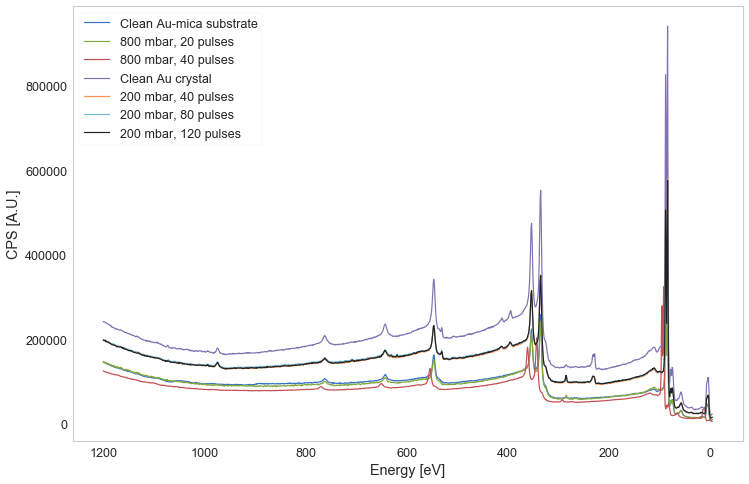

In [124]:
fig = plt.figure(figsize=(12, 8))
for j, d in enumerate(aliset):
    d.plot_region(region)

### Only Au-mica (800 mbar series)

Text(0.5, 1.0, 'Experiments on Au-mica substrate')

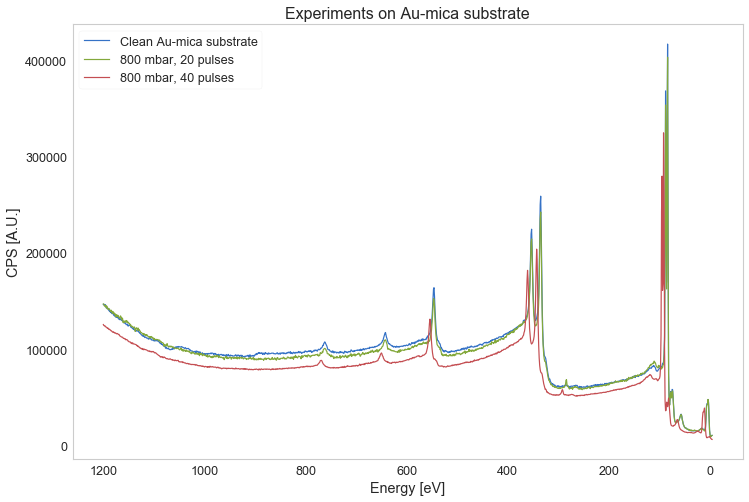

In [126]:
fig = plt.figure(figsize=(12, 8))
for j, d in enumerate(aliset[:3]):
    d.plot_region(region)
plt.title('Experiments on Au-mica substrate', fontsize = 16)

### Only Au-crystal (200 mbar series)

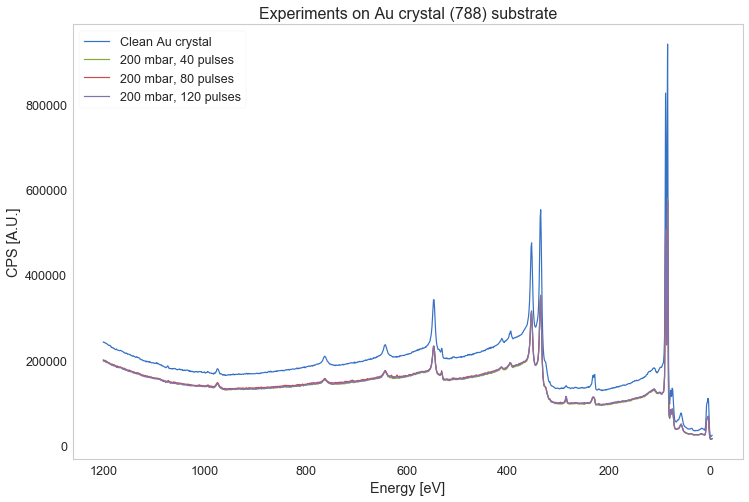

In [128]:
fig = plt.figure(figsize=(12, 8))
for j, d in enumerate(aliset[3:]):
    d.plot_region(region)
plt.title('Experiments on Au crystal (788) substrate', fontsize = 16)
plt.gca().invert_xaxis()

## Ba 

In [248]:
region = 'Ba_3d'

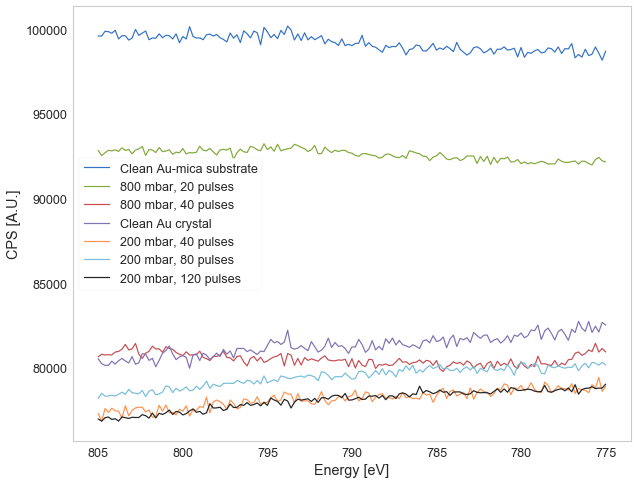

In [261]:
plt.figure(figsize=(10,8))
for d in aliset:
    d.plot_region(region)

Text(0.5, 1.0, 'Ba 3d region')

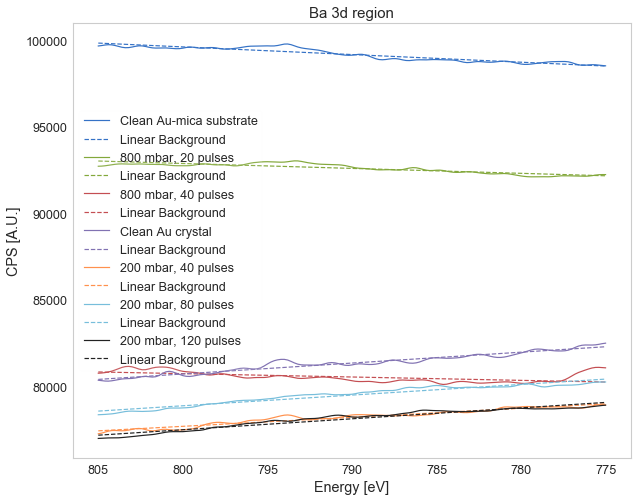

In [252]:
fig = plt.figure(figsize=(10, 8))

for j, d in enumerate(aliset):
    d.gaussian_smooth(region)
    d.subtract_linear_bg(region)
    
plt.legend(loc='center left', framealpha=0.1)
plt.title('Ba 3d region', fontsize = 15)

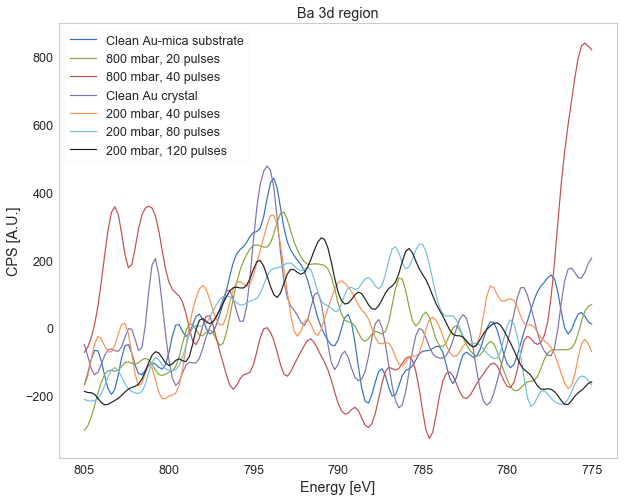

In [253]:
fig = plt.figure(figsize=(10, 8))
fits_bali = []
for j, d in enumerate(aliset):
    d.plot_region(region, lb = lb[j])
#     if j == 0:
#         d.plot_region(region)
#     else:
#         fits_bali.append(d.fit_double_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left')
# plt.gca().invert_xaxis()

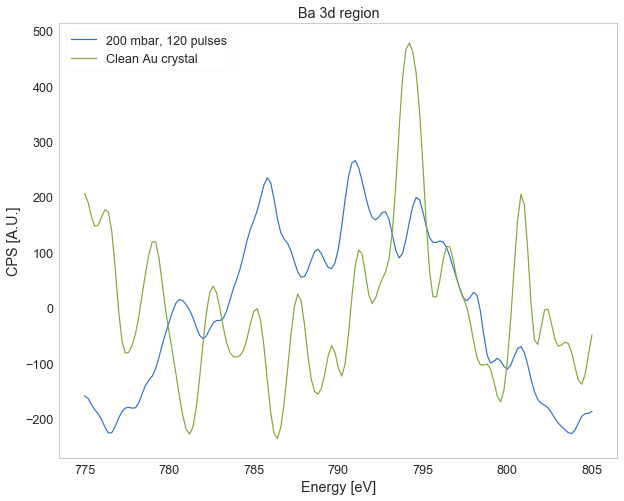

In [259]:
fig = plt.figure(figsize=(10, 8))

Lowp120.plot_region(region, lb = lb[-1])
AuCrystal.plot_region(region, lb = lb[3])

plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left')
# plt.gca().invert_xaxis()

### No Ba appreciable with ALI
Integrate areas anyway

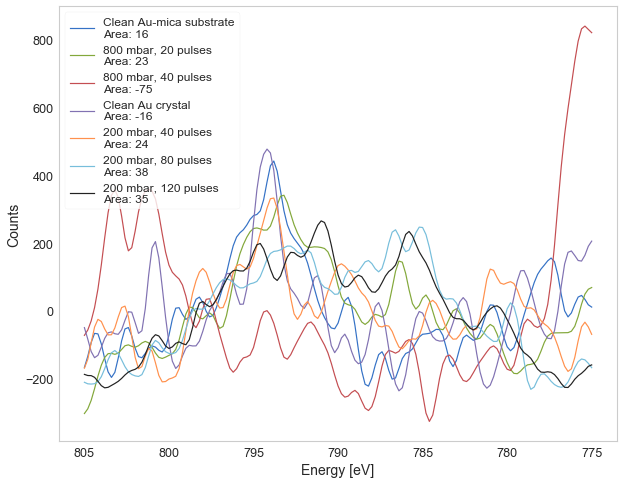

In [228]:
plt.figure(figsize=(10, 8))
# data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_bali = []
for j, d in enumerate(aliset):
    area_bali.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j]))

## C

In [229]:
region = 'C_1s'

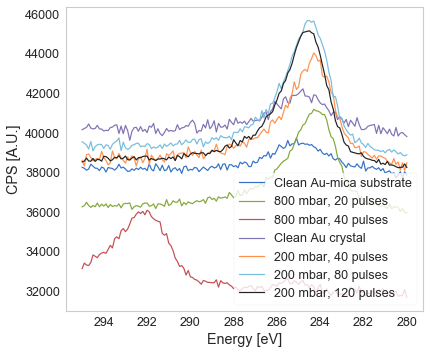

In [230]:
for j, d in enumerate(aliset):
#     d.__init__(path=files[j], name=lb[j])
    d.plot_region(region)

specs.shirley_calculate: Max iterations exceeded before convergence.


Text(0.5, 1.0, 'C1s region')

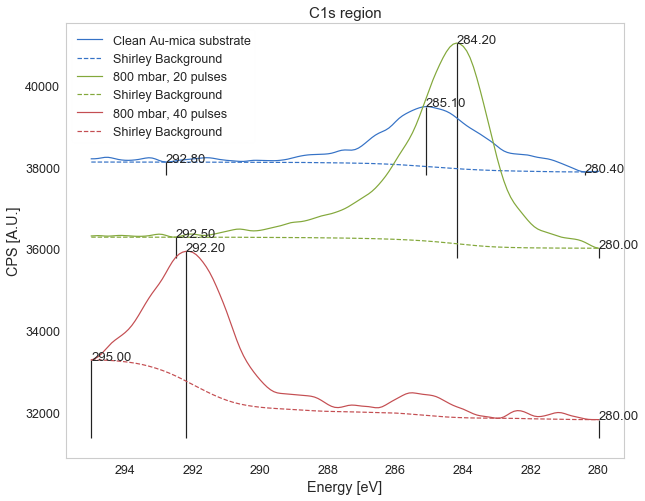

In [231]:
fig = plt.figure(figsize=(10, 8))

for j, d in enumerate(aliset[:3]):
    d.gaussian_smooth(region)
    d.subtract_shirley_bg(region)
    
plt.legend(loc='upper left', framealpha=0.1)
plt.title(region.replace('_', '')+' region', fontsize = 15)

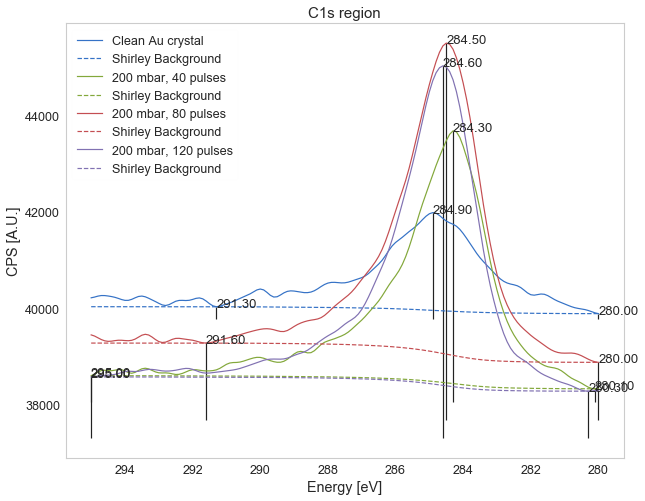

In [232]:
fig = plt.figure(figsize=(10, 8))

for j, d in enumerate(aliset[3:]):
    d.gaussian_smooth(region)
    d.subtract_shirley_bg(region)
    
plt.legend(loc='upper left', framealpha=0.1)
plt.title(region.replace('_', '')+' region', fontsize = 15)
plt.gca().invert_xaxis()

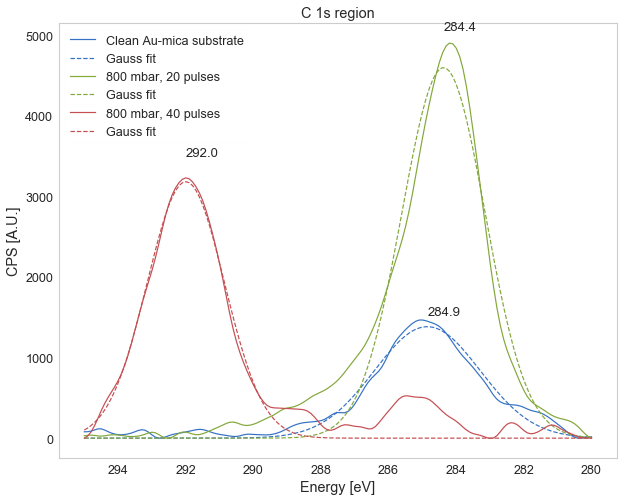

In [233]:
fig = plt.figure(figsize=(10, 8))
fits_cali = []
for j, d in enumerate(aliset[:3]):
    fits_cali.append(d.fit_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left', framealpha=0.1)
plt.gca().invert_xaxis()

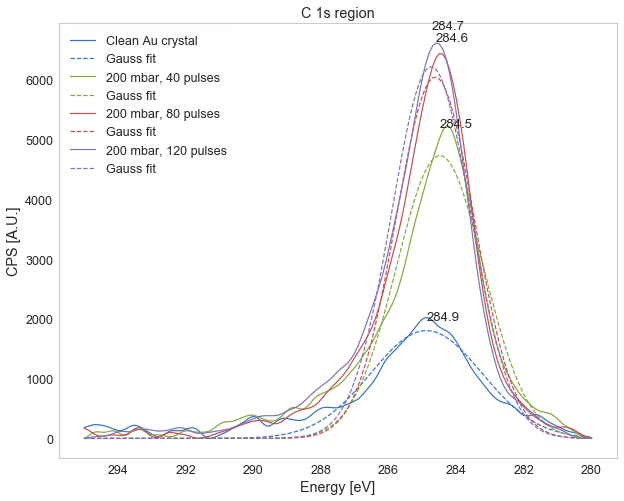

In [234]:
fig = plt.figure(figsize=(10, 8))
fits_cali = []
for j, d in enumerate(aliset[3:]):
    fits_cali.append(d.fit_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left', framealpha=0.1)
plt.gca().invert_xaxis()

### Integrate areas

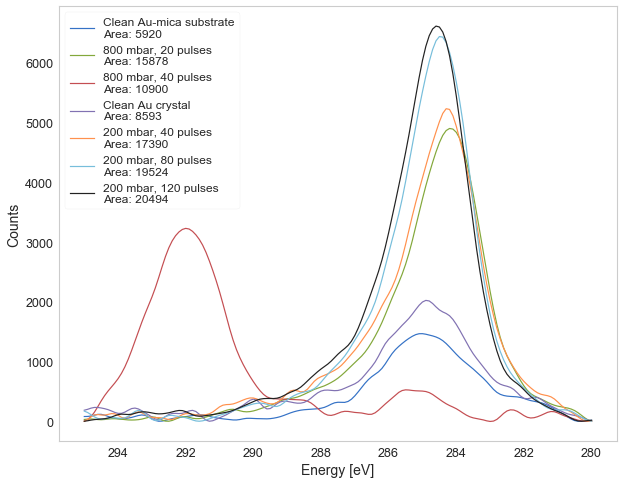

In [235]:
plt.figure(figsize=(10, 8))
# data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_cali = []
for j, d in enumerate(aliset):
    area_cali.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j]))

In [236]:
hipRatios, lowpRatios

([2.682000869111824, 1.8411526137275513],
 [2.085043350561429, 2.369373861856095, 2.5043728930721474])

Text(0.5, 1.0, 'C abundance in ALI depositions')

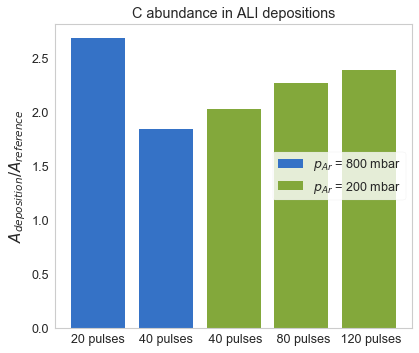

In [237]:
hipRatios = [a/area_cali[0] for a in area_cali[1:3]]
lowpRatios = [a/area_cali[3] for a in area_cali[4:]]


plt.bar([s.replace('800 mbar, ','') for s in lb[1:3]], [x for x in hipRatios], label='$p_{Ar}$ = 800 mbar')
plt.bar([s.replace('200 mbar,','') for s in lb[4:]], [x for x in lowpRatios], label='$p_{Ar}$ = 200 mbar')

plt.legend(loc='center right')
plt.ylabel('$A_{deposition}/A_{reference}$', fontsize=15)
plt.title('C abundance in ALI depositions')

## O

In [189]:
region = 'O_1s'

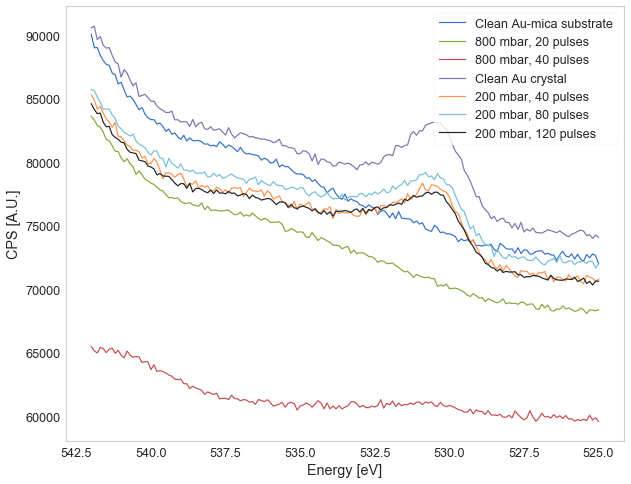

In [219]:
fig = plt.figure(figsize=(10,8))
for j, d in enumerate(aliset):
    d.__init__(path=files[j], name=lb[j])
    if j >= 3:
        d.reverse_energy_scale()
    d.plot_region(region)

Clean Au-mica substrate
800 mbar, 20 pulses
800 mbar, 40 pulses


Text(0.5, 1.0, 'O1s region')

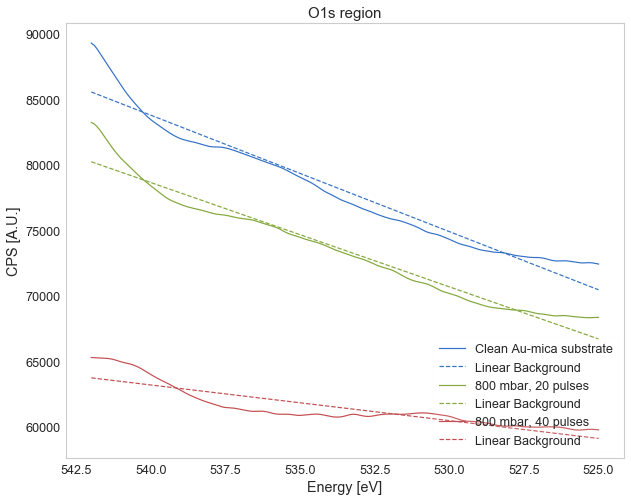

In [206]:
fig = plt.figure(figsize=(10, 8))

for j, d in enumerate(aliset[:3]):
    print(lb[j])
    d.gaussian_smooth(region)
    d.subtract_linear_bg(region)
#         d.subtract_shirley_bg(region, maxit = 20)
   
plt.legend(loc='lower right', framealpha=0.1)
plt.title(region.replace('_', '')+' region', fontsize = 15)

specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.
specs.shirley_calculate: Max iterations exceeded before convergence.


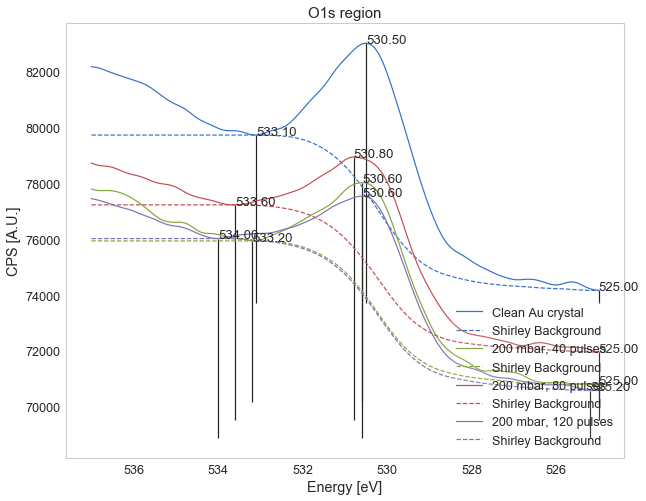

In [207]:
fig = plt.figure(figsize=(10, 8))

for j, d in enumerate(aliset[3:]):
    d.gaussian_smooth(region)
    d.df[region] = d.df[region][d.df[region]['energy'] < 537.]
    d.subtract_shirley_bg(region, maxit=20)
    
plt.legend(loc='lower right', framealpha=0.1)
plt.title(region.replace('_', '')+' region', fontsize = 15)
plt.gca().invert_xaxis()

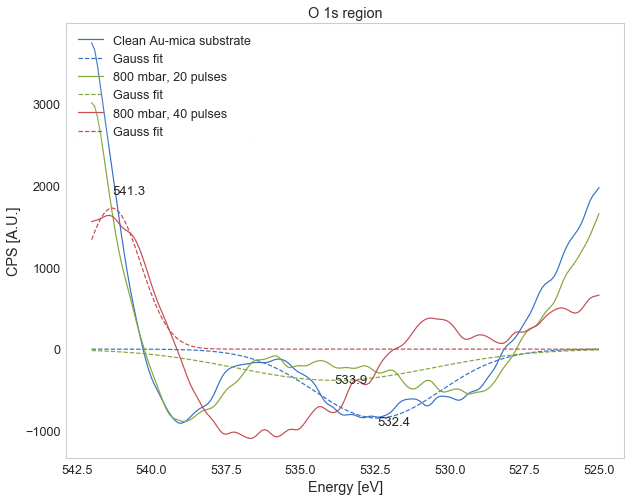

In [208]:
fig = plt.figure(figsize=(10, 8))
fits_oli = []
for j, d in enumerate(aliset[:3]):
    fits_oli.append(d.fit_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left', framealpha=0.1)
plt.gca().invert_xaxis()

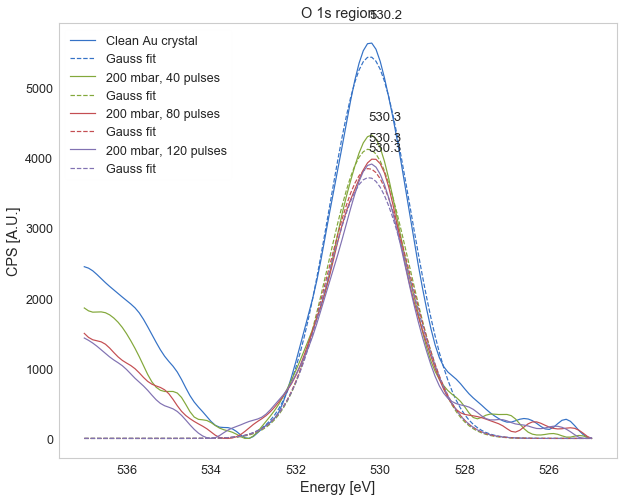

In [211]:
fig = plt.figure(figsize=(10, 8))
fits_oli = []
for j, d in enumerate(aliset[3:]):
    fits_oli.append(d.fit_gauss(region))
plt.title(region.replace('_',' ')+ ' region')
plt.legend(loc='upper left', framealpha=0.1)
plt.gca().invert_xaxis()

### Integrate areas

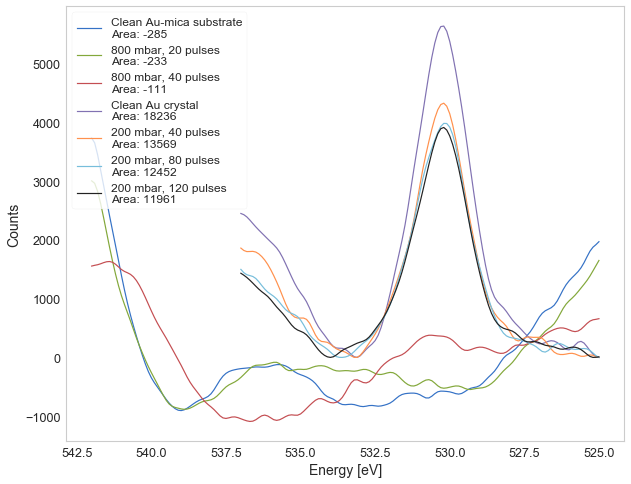

In [212]:
plt.figure(figsize=(10, 8))
# data[0].plot_region(region, lb= lb[0] + ' (reference)')

area_oli = []
for j, d in enumerate(aliset):
    area_oli.append(plot_xps_element_spectra(data[0].df[region].dropna(), d.df[region].dropna(), lb[j]))

In [213]:
hipRatios, lowpRatios

([2.682000869111824, 1.8411526137275513],
 [2.085043350561429, 2.369373861856095, 2.5043728930721474])

Text(0.5, 1.0, 'O abundance in ALI depositions')

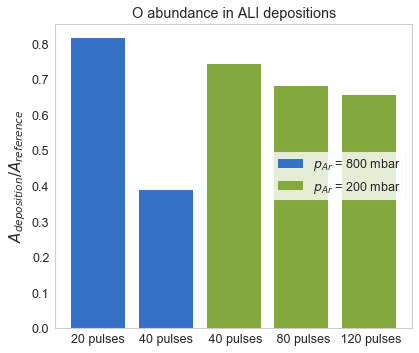

In [262]:
hipRatios = [a/area_oli[0] for a in area_oli[1:3]]
lowpRatios = [a/area_oli[3] for a in area_oli[4:]]


plt.bar([s.replace('800 mbar, ','') for s in lb[1:3]], [x for x in hipRatios], label='$p_{Ar}$ = 800 mbar')
plt.bar([s.replace('200 mbar,','') for s in lb[4:]], [x for x in lowpRatios], label='$p_{Ar}$ = 200 mbar')

plt.legend(loc='center right')
plt.ylabel('$A_{deposition}/A_{reference}$', fontsize=15)
plt.title('O abundance in ALI depositions')

## Stoichiometry

In [244]:
area_bali, area_cali, area_oli

([15.53548453797464,
  23.377210392083498,
  -74.98651824169815,
  -15.707543398734174,
  23.81278589562629,
  37.82372303086031,
  34.66584251309528],
 [5920.114292317528,
  15877.751677236942,
  10899.83390286625,
  8593.005158579617,
  17389.815436942496,
  19523.981523992785,
  20494.347745623123],
 [-285.1565190907795,
  -232.72289001269283,
  -110.67553915167764,
  18235.805757444912,
  13569.119806868803,
  12451.581841655161,
  11960.974523121007])

In [247]:
asf = [7.49, 0.296, 0.711, 0.770]
print('Relative abundance | C/Ba | O/Ba | C/O | ')
for i in range(7):
    print('| ', lb[i], '| %.1f | %.1f | %.1f | ' %( area_cali[i]*asf[0] / (area_bali[i]*asf[1])  , 
          area_oli[i]*asf[0] / (area_bali[i]*asf[2]), 
          area_cali[i]*asf[2] / (area_oli[i]*asf[1]) ) )

Relative abundance | C/Ba | O/Ba | C/O | 
|  Clean Au-mica substrate | 9642.6 | -193.4 | -49.9 | 
|  800 mbar, 20 pulses | 17186.5 | -104.9 | -163.9 | 
|  800 mbar, 40 pulses | -3678.1 | 15.5 | -236.6 | 
|  Clean Au crystal | -13842.9 | -12230.1 | 1.1 | 
|  200 mbar, 40 pulses | 18478.8 | 6002.8 | 3.1 | 
|  200 mbar, 80 pulses | 13061.5 | 3467.9 | 3.8 | 
|  200 mbar, 120 pulses | 14959.7 | 3634.8 | 4.1 | 
